Begun 2/15/24

Notebook to test what mask window function is correct using only healpy code and mask

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell,DlTT,DlEE,DlBB,DlTE= np.loadtxt("/home/zbh5/act_analysis/scripts/camb_19413797_lensedtotcls.dat", usecols=(0,1,2,3,4), unpack=True) 
# Note that ell runs from 2 to 5400
# convert Dl to Cl
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
ClEE = DlEE * 2 * np.pi / (ell*(ell+1.))
ClTE = DlTE * 2 * np.pi / (ell*(ell+1.))
ClBB = DlBB * 2 * np.pi / (ell*(ell+1.))

In [5]:
# Making healpy sim of unrotated map
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))
unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
print(unrot_sim_maps.shape)
CMB_Q = unrot_sim_maps[1]
CMB_U = unrot_sim_maps[2]

6.870972823634812
(3, 3145728)


In [4]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

In [6]:
def get_pixels(nside, dec, ra):
    npix = int(nside)**2*12
    allpix = np.arange(npix)
    alldec = hp.pix2ang(nside, allpix)[0]
    allRA = hp.pix2ang(nside, allpix)[1]
    cross0 = 0
    if 0 > np.min(ra) and np.max(ra) > 0:
        print("RA crossing 0")
        cross0 = 1
    dec_lim = np.radians(np.array([dec[0], dec[1]])*(-1.0) + 90.0)
    RA_lim = np.radians(np.array([ra[0], ra[1]]))
    if cross0:
        keep1 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > 0))[0] 
        keep2 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA - 2 * np.pi > RA_lim[0]) & (allRA - 2 * np.pi < 0))[0]
        keep = np.append(np.array(keep1), np.array(keep2))
    else:
        keep = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > RA_lim[0]))[0] 
    return keep


def eq_to_gal(nside, pix):
    lat, lon = hp.pix2ang(nside, pix)
    r = hp.Rotator(coord=['C','G'])
    lat, lon = r(lat, lon)
    temp = hp.ang2pix(nside, lat, lon)
    temp = list(set(temp))
    try:
        assert len(pix) == len(temp)
    except AssertionError:
        print("lost %i pixels out of %i pixels"%(len(pix)-len(temp),len(pix)))
    return temp


def fill_missing_pix(nside, pix, nside_out):
    testmap = np.zeros(nside ** 2 * 12)
    testmap[pix] = 1
    # hp.mollview(testmap)
    # plt.show()
    # exit()
    testmap[testmap == 0] = -0.01
    testmap = hp.smoothing(testmap, sigma = np.radians(0.1), iter = 1)
    testmap[testmap < 0] = 0
    testmap[testmap != 0] = 1
    return hp.ud_grade(testmap, nside_out)

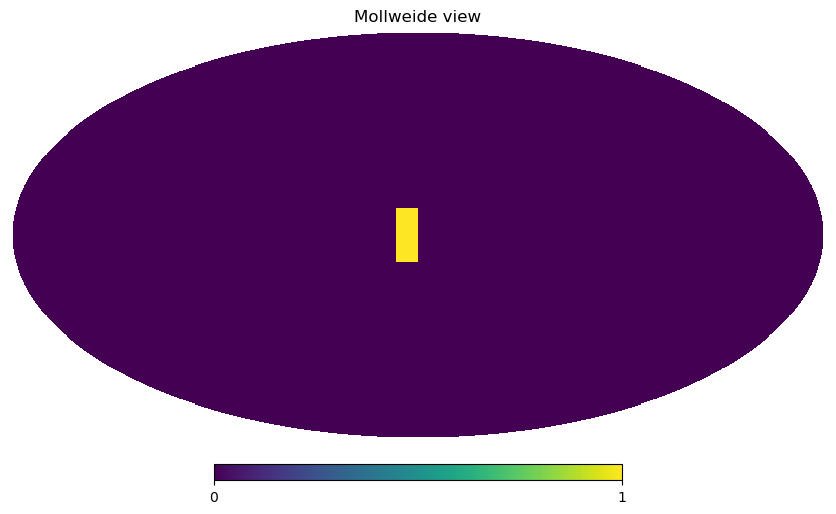

In [7]:
# Example mask
ra = [0,10]
dec = [10,-10]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
hp.mollview(m)

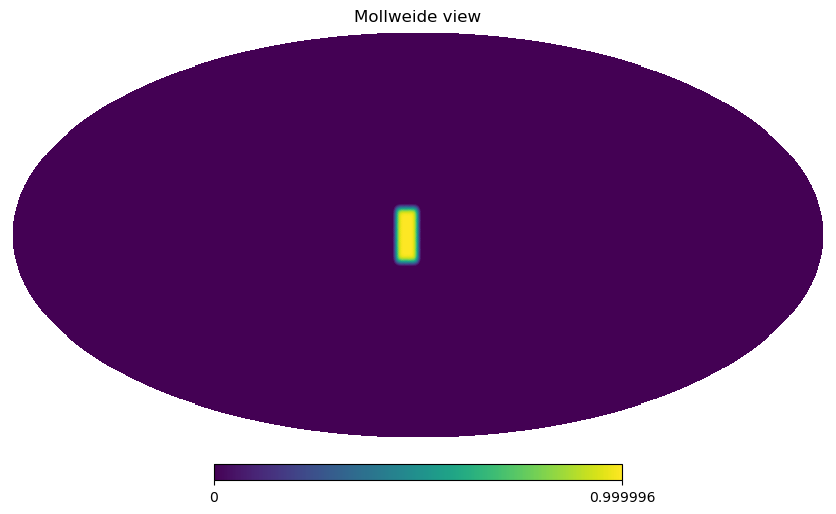

In [8]:
# Example tapering of mask
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

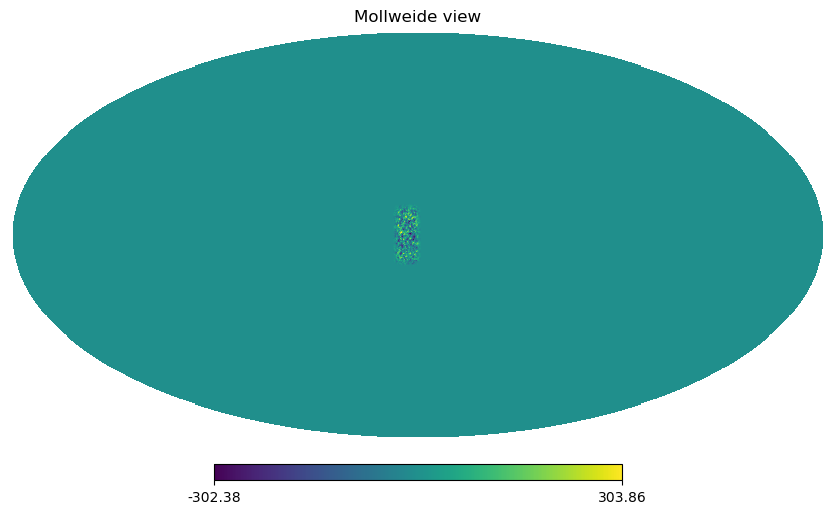

In [13]:
#hp.mollview(unrot_sim_maps[0])
hp.mollview(m_sm*unrot_sim_maps[0])

In [17]:
# Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2: ")
print(output_angles_only * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 6.31656466  4.8838293  -6.89845216  1.31447462 -3.67133836  1.31042185
  4.34634999  2.33209001  3.66401186  0.30202776]
Output angle: (-3.0696465208555006, 0.14554079362447345)
Output angle: (-2.373453570212609, 0.1123590059029008)
Output angle: (3.352377528862487, 0.15906348477344784)
Output angle: (-0.6388371386327835, 0.030178457490250336)
Output angle: (1.7842387683532415, 0.08438170567565362)
Output angle: (-0.6368675002648283, 0.03008538180983041)
Output angle: (-2.1122675482963453, 0.09994693412200586)
Output angle: (-1.1333923980818494, 0.053560095146745174)
Output angle: (-1.7806783269720952, 0.08421288880390093)
Output angle: (-0.14678650354565984, 0.006933061300530669)
Injected rotation angles: 
[ 6.31656466  4.8838293  -6.89845216  1.31447462 -3.67133836  1.31042185
  4.34634999  2.33209001  3.66401186  0.30202776]
Calculated angles scaled by -2: 
[ 6.13929304  4.74690714 -6.70475506  1.27767428 -3.56847754  1.273735
  4.2245351   2.2667848   3.56135665

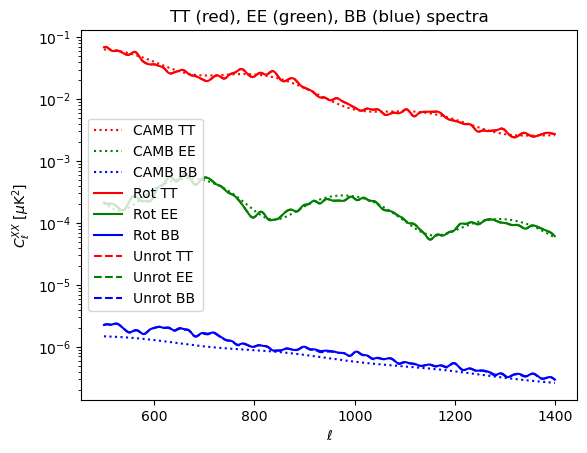

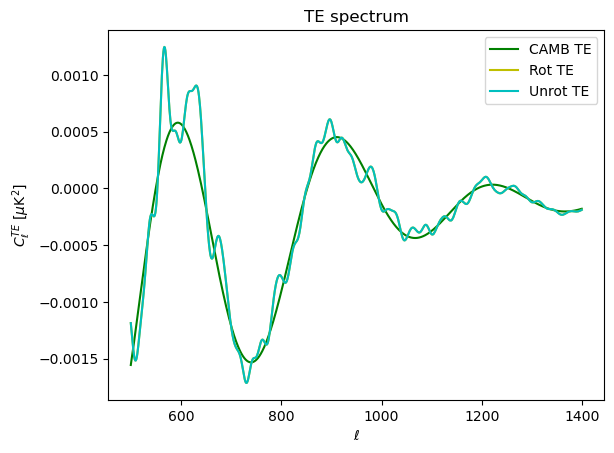

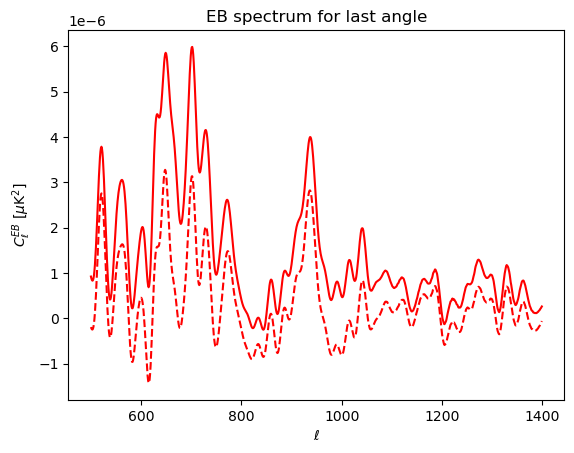

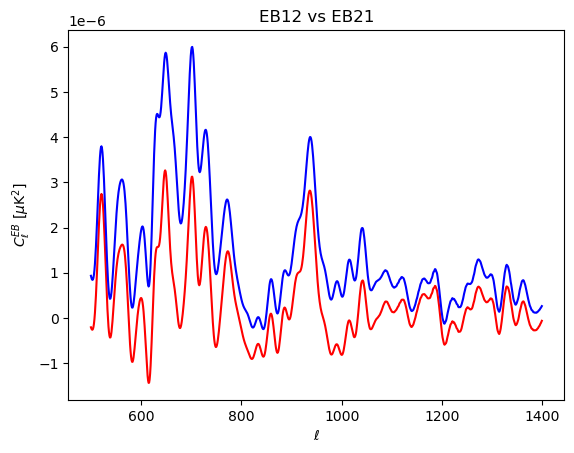

In [18]:
plt.semilogy(ell_hp,ClTT[min_ell-2:max_ell-2],'r:',label='CAMB TT')
plt.semilogy(ell_hp,ClEE[min_ell-2:max_ell-2],'g:',label='CAMB EE')
plt.semilogy(ell_hp,ClBB[min_ell-2:max_ell-2],'b:',label='CAMB BB')
plt.semilogy(ell_hp,ClTT_rot,'r',label='Rot TT')
plt.semilogy(ell_hp,ClEE_rot,'g',label='Rot EE')
plt.semilogy(ell_hp,ClBB_rot,'b',label='Rot BB')
plt.semilogy(ell_hp,ClTT_unrot,'r--',label='Unrot TT')
plt.semilogy(ell_hp,ClEE_unrot,'g--',label='Unrot EE')
plt.semilogy(ell_hp,ClBB_unrot,'b--',label='Unrot BB')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$C^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

plt.plot(ell_hp,ClTE[min_ell-2:max_ell-2],'g',label='CAMB TE')
plt.plot(ell_hp,ClTE_rot,'y',label='Rot TE')
plt.plot(ell_hp,ClTE_unrot,'c',label='Unrot TE')
plt.ylabel('$C^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_rot,'r',label='Rot')
plt.plot(ell_hp,ClEB_unrot,'r--',label='Unrot')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB spectrum for last angle')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_cross12,'r')
plt.plot(ell_hp,ClEB_cross21,'b')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB12 vs EB21')
plt.show()

In [19]:
# Same calculation, but with w2w4 instead of w2

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
# Use same angles as last time
#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2w4 with snippet from Steve/Blake
    w2w4 = (np.mean(m_sm**2.)**2./np.mean(m_sm**4.)) #If the numerator is supposed to be w2 it actually squares the mean of the square - should I do that?
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2w4
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2w4
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2w4
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2w4
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2w4
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2w4
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2w4
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2w4
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2w4
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2w4
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2w4
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2w4
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2w4
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2w4
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2w4
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2w4
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2w4
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2w4
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2w4
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2w4
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2w4
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2w4
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2w4
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2w4
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2: ")
print(output_angles_only * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 6.31656466  4.8838293  -6.89845216  1.31447462 -3.67133836  1.31042185
  4.34634999  2.33209001  3.66401186  0.30202776]
Output angle: (-2.5610579461422276, 0.12128578336986232)
Output angle: (-1.9806863396720065, 0.09370037690776771)
Output angle: (2.79662382293286, 0.1325096133312148)
Output angle: (-0.5332955151124731, 0.02519144390720807)
Output angle: (1.489206639806181, 0.07040122756171223)
Output angle: (-0.5316513625644772, 0.02511376076570748)
Output angle: (-1.7628524516673005, 0.08336772125729917)
Output angle: (-0.9460937122982147, 0.04470197215655332)
Output angle: (-1.4862361211804864, 0.07026054660374828)
Output angle: (-0.12253903159461375, 0.005787782605057485)
Injected rotation angles: 
[ 6.31656466  4.8838293  -6.89845216  1.31447462 -3.67133836  1.31042185
  4.34634999  2.33209001  3.66401186  0.30202776]
Calculated angles scaled by -2: 
[ 5.12211589  3.96137268 -5.59324765  1.06659103 -2.97841328  1.06330273
  3.5257049   1.89218742  2.97247224 

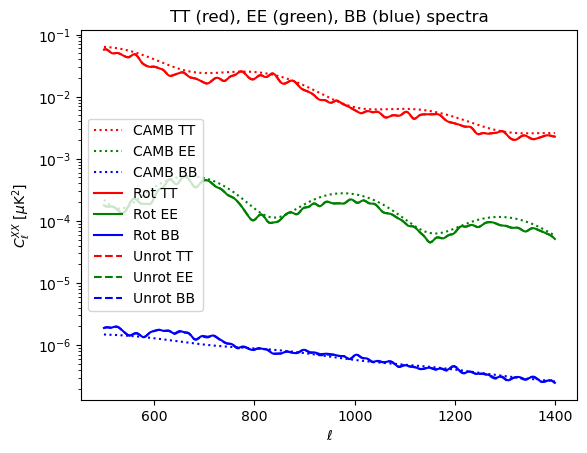

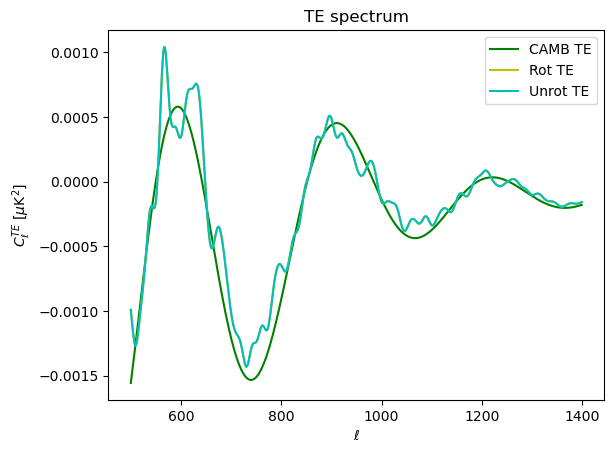

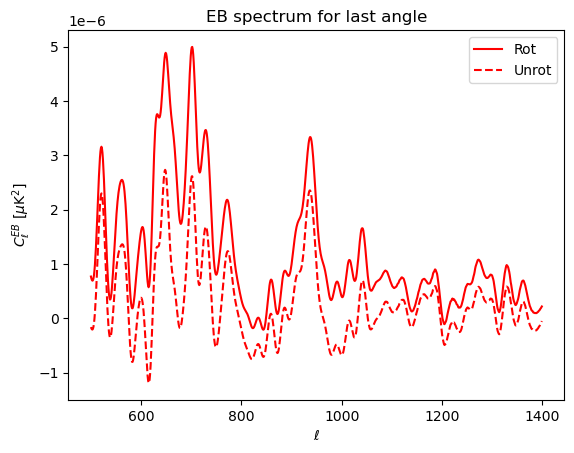

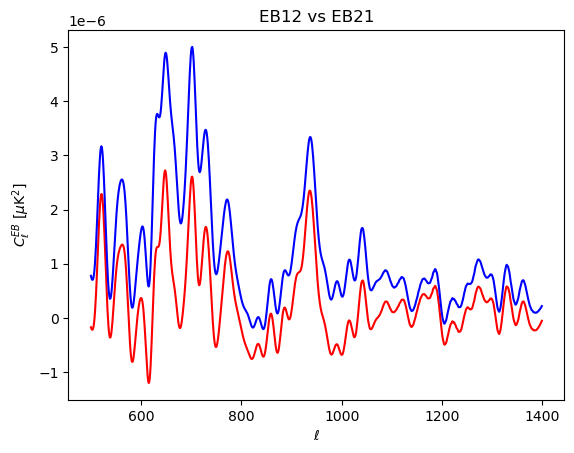

In [20]:
plt.semilogy(ell_hp,ClTT[min_ell-2:max_ell-2],'r:',label='CAMB TT')
plt.semilogy(ell_hp,ClEE[min_ell-2:max_ell-2],'g:',label='CAMB EE')
plt.semilogy(ell_hp,ClBB[min_ell-2:max_ell-2],'b:',label='CAMB BB')
plt.semilogy(ell_hp,ClTT_rot,'r',label='Rot TT')
plt.semilogy(ell_hp,ClEE_rot,'g',label='Rot EE')
plt.semilogy(ell_hp,ClBB_rot,'b',label='Rot BB')
plt.semilogy(ell_hp,ClTT_unrot,'r--',label='Unrot TT')
plt.semilogy(ell_hp,ClEE_unrot,'g--',label='Unrot EE')
plt.semilogy(ell_hp,ClBB_unrot,'b--',label='Unrot BB')
plt.title('TT (red), EE (green), BB (blue) spectra')
plt.ylabel('$C^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

plt.plot(ell_hp,ClTE[min_ell-2:max_ell-2],'g',label='CAMB TE')
plt.plot(ell_hp,ClTE_rot,'y',label='Rot TE')
plt.plot(ell_hp,ClTE_unrot,'c',label='Unrot TE')
plt.ylabel('$C^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('TE spectrum')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_rot,'r',label='Rot')
plt.plot(ell_hp,ClEB_unrot,'r--',label='Unrot')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB spectrum for last angle')
plt.legend()
plt.show()

plt.plot(ell_hp,ClEB_cross12,'r')
plt.plot(ell_hp,ClEB_cross21,'b')
plt.ylabel('$C^{EB}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('EB12 vs EB21')
plt.show()

In [26]:
print(w2)
print(w2w4)
print(0.97*w2w4/w2)

0.003749871996345702
0.004491873709860829
1.1619376615551333


In [27]:
# Same calculation, but with no mask correction

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
# Use same angles as last time
#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] 
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] 
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] 
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] 
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] 
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] 
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] 
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] 
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] 
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] 
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] 
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] 
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] 
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] 
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] 
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] 
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] 
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] 
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2: ")
print(output_angles_only * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 6.31656466  4.8838293  -6.89845216  1.31447462 -3.67133836  1.31042185
  4.34634999  2.33209001  3.66401186  0.30202776]
Output angle: (-0.011464817644862187, 0.0004700753487262175)
Output angle: (-0.008968258759731937, 0.00024331739670566889)
Output angle: (0.012550629104829843, 0.0005469675028050101)
Output angle: (-0.0022701403393914727, 0.0005857801634563221)
Output angle: (0.006602291599068607, 5.773396453053687e-05)
Output angle: (-0.002090989567136503, 0.0005142929952033846)
Output angle: (-0.007815602827729438, 0.00015645410700560497)
Output angle: (-0.004200084085414404, 3.347220814111482e-07)
Output angle: (-0.006601830998932866, 5.370665791022841e-05)
Output angle: (-0.0006000120002411791, 0.0)
Injected rotation angles: 
[ 6.31656466  4.8838293  -6.89845216  1.31447462 -3.67133836  1.31042185
  4.34634999  2.33209001  3.66401186  0.30202776]
Calculated angles scaled by -2: 
[ 0.02292964  0.01793652 -0.02510126  0.00454028 -0.01320458  0.00418198
  0.01563

=============================================================================

Trying another mask

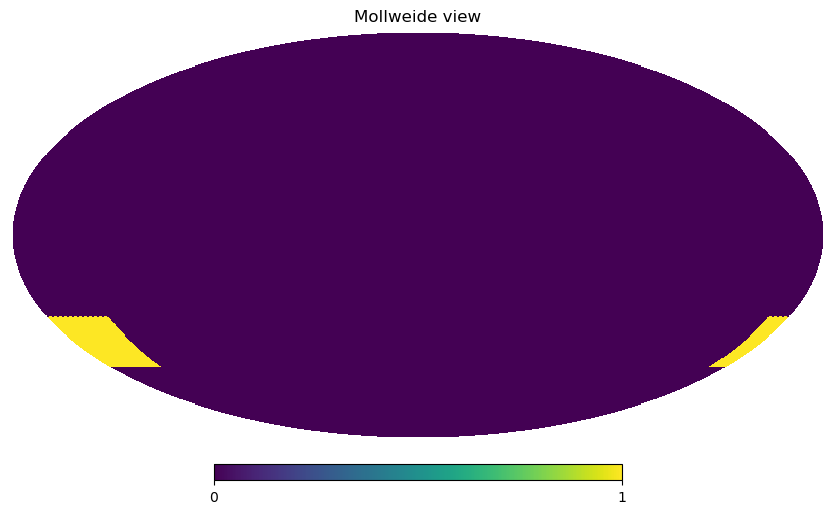

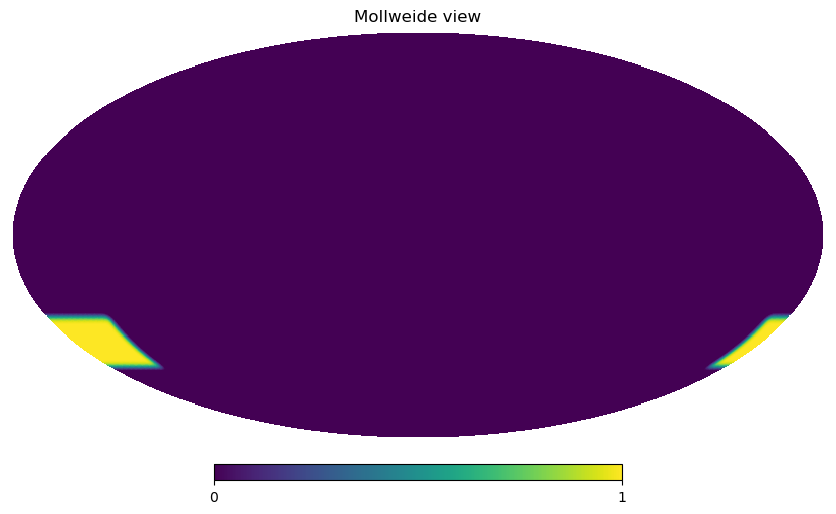

In [28]:
# Example mask
ra = [150,190]
dec = [-30,-50]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
hp.mollview(m)

m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [30]:
#Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2: ")
print(output_angles_only * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle: (-2.45780889923588, 0.11589436536090984)
Output angle: (-0.5688164746694336, 0.026759581366652466)
Output angle: (3.548476132196355, 0.16776998789924355)
Output angle: (2.982557262263871, 0.14080146089972112)
Output angle: (1.4887194374525687, 0.07008950872279276)
Output angle: (-0.458344976040066, 0.02156153479600372)
Output angle: (-1.6422531756613588, 0.07733300821240932)
Output angle: (0.6529268987939217, 0.030717776727890302)
Output angle: (0.7486719774685917, 0.035224139802964786)
Output angle: (0.37024913412585014, 0.017416801947755415)
Injected rotation angles: 
[ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Calculated angles scaled by -2: 
[ 4.9156178   1.13763295 -7.09695226 -5.96511452 -2.97743887  0.91668995
  3.28450635 -1.3058538  -1.49734395 -0

In [31]:
# Same calculation, but with w2w4 instead of w2

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
# Use same angles as last time
#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2w4 with snippet from Steve/Blake
    w2w4 = (np.mean(m_sm**2.)**2./np.mean(m_sm**4.)) #If the numerator is supposed to be w2 it actually squares the mean of the square - should I do that?
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2w4
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2w4
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2w4
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2w4
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2w4
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2w4
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2w4
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2w4
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2w4
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2w4
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2w4
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2w4
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2w4
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2w4
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2w4
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2w4
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2w4
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2w4
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2w4
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2w4
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2w4
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2w4
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2w4
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2w4
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2: ")
print(output_angles_only * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle: (-2.2472750882181516, 0.10592432711037623)
Output angle: (-0.5201932207662583, 0.024471609046820216)
Output angle: (3.243790340508235, 0.15323528512094306)
Output angle: (2.726808322140569, 0.1286515455061135)
Output angle: (1.361374114449213, 0.06408461201445)
Output angle: (-0.4191665978719234, 0.0197182250553058)
Output angle: (-1.5017500278621716, 0.07070411095928007)
Output angle: (0.597111683964432, 0.02809108532599005)
Output angle: (0.684668914475191, 0.03221167402156394)
Output angle: (0.3386018437007639, 0.01592794458825507)
Injected rotation angles: 
[ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Calculated angles scaled by -2: 
[ 4.49455018  1.04038644 -6.48758068 -5.45361664 -2.72274823  0.8383332
  3.00350006 -1.19422337 -1.36933783 -0.67720369]

In [32]:
print(w2)
print(w2w4)

0.013042512382478054
0.014261459494569395


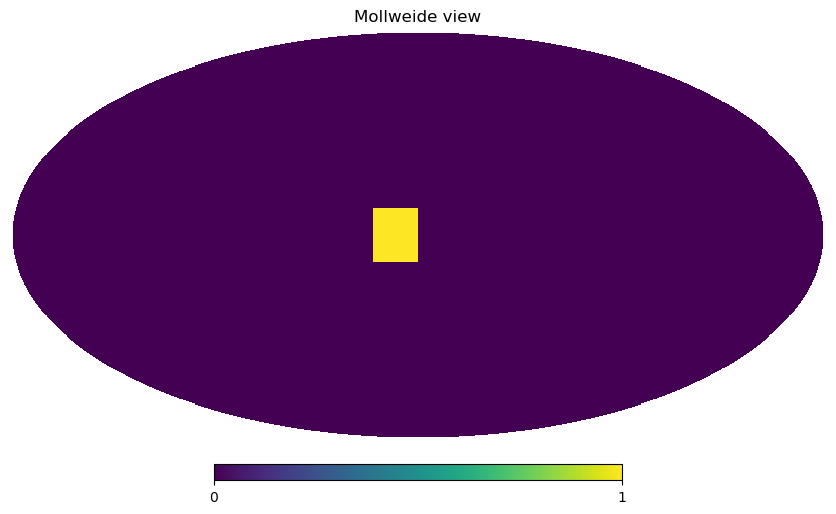

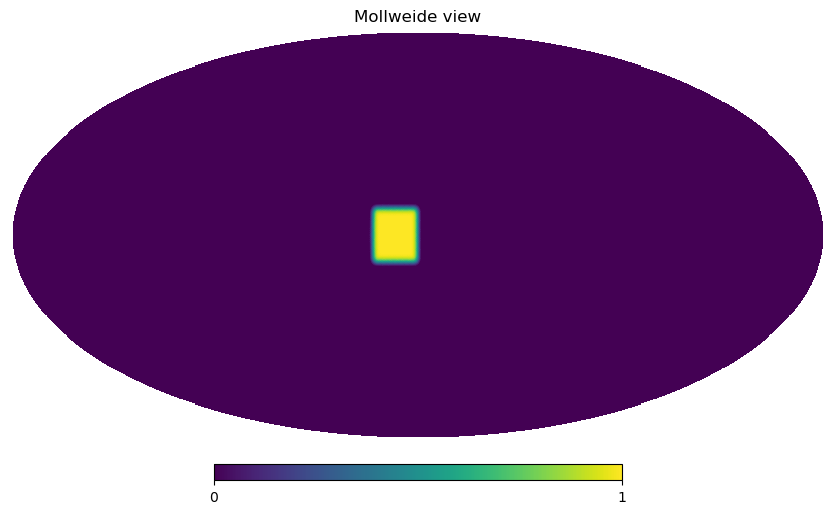

In [40]:
# Example mask
ra = [0,20]
dec = [10,-10]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
hp.mollview(m)

m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [41]:
#Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)

print('w2')
print(w2)
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2: ")
print(output_angles_only * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle: (-2.3966333035862735, 0.11317244831016558)
Output angle: (-0.5546907419188312, 0.026135607085423722)
Output angle: (3.4599213623951544, 0.1637970167510084)
Output angle: (2.908235648778045, 0.13748264941799865)
Output angle: (1.451721333297476, 0.0684512808552561)
Output angle: (-0.446963157576009, 0.021058839197228018)
Output angle: (-1.6014315747252086, 0.07552438167929192)
Output angle: (0.6367117414588037, 0.03000141352342654)
Output angle: (0.7300780379397558, 0.03440254596565814)
Output angle: (0.36105521673623076, 0.0170107758348091)
w2
0.008224621879493504
Injected rotation angles: 
[ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Calculated angles scaled by -2: 
[ 4.79326661  1.10938148 -6.91984272 -5.8164713  -2.90344267  0.89392632
  3.20286315 -1.27

In [42]:
# Same calculation, but with w2w4 instead of w2

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
# Use same angles as last time
#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2w4 with snippet from Steve/Blake
    w2w4 = (np.mean(m_sm**2.)**2./np.mean(m_sm**4.)) #If the numerator is supposed to be w2 it actually squares the mean of the square - should I do that?
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2w4
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2w4
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2w4
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2w4
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2w4
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2w4
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2w4
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2w4
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2w4
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2w4
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2w4
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2w4
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2w4
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2w4
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2w4
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2w4
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2w4
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2w4
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2w4
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2w4
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2w4
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2w4
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2w4
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2w4
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)

print('w2w4')
print(w2w4)
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2: ")
print(output_angles_only * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle: (-2.1460006658278767, 0.10129037745851811)
Output angle: (-0.4967938168483263, 0.023407075324489768)
Output angle: (3.097296696455669, 0.14648791885407975)
Output angle: (2.603809796656838, 0.1230073877405821)
Output angle: (1.3000991025512987, 0.06129165419225029)
Output angle: (-0.4003122791833315, 0.018860563504600573)
Output angle: (-1.4341462290442715, 0.06762119285438938)
Output angle: (0.5702514307444572, 0.026868977319351037)
Output angle: (0.6538686826864988, 0.03081011286680404)
Output angle: (0.3233717264493865, 0.015235194673235839)
w2w4
0.009183013009241289
Injected rotation angles: 
[ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Calculated angles scaled by -2: 
[ 4.29200133  0.99358763 -6.19459339 -5.20761959 -2.60019821  0.80062456
  2.86829246

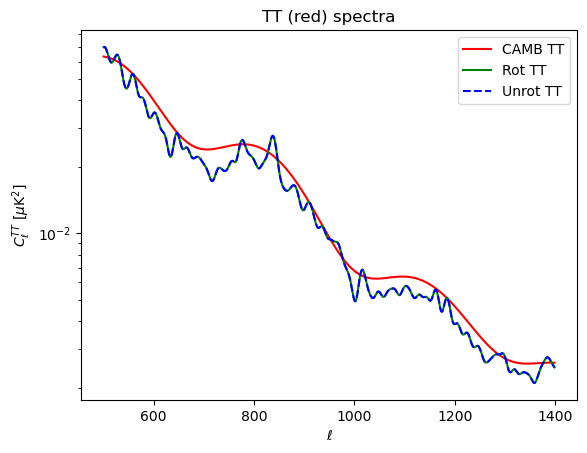

In [43]:
plt.semilogy(ell_hp,ClTT[min_ell-2:max_ell-2],'r',label='CAMB TT')
#plt.semilogy(ell_hp,ClEE[min_ell-2:max_ell-2],'g:',label='CAMB EE')
#plt.semilogy(ell_hp,ClBB[min_ell-2:max_ell-2],'b:',label='CAMB BB')
plt.semilogy(ell_hp,ClTT_rot,'g',label='Rot TT')
#plt.semilogy(ell_hp,ClEE_rot,'g',label='Rot EE')
#plt.semilogy(ell_hp,ClBB_rot,'b',label='Rot BB')
plt.semilogy(ell_hp,ClTT_unrot,'b--',label='Unrot TT')
#plt.semilogy(ell_hp,ClEE_unrot,'g--',label='Unrot EE')
#plt.semilogy(ell_hp,ClBB_unrot,'b--',label='Unrot BB')
plt.title('TT (red) spectra')
plt.ylabel('$C^{TT}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

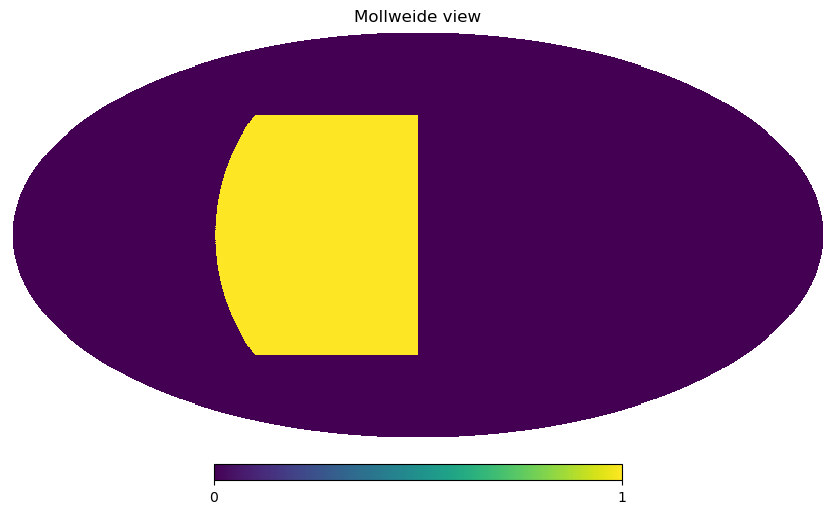

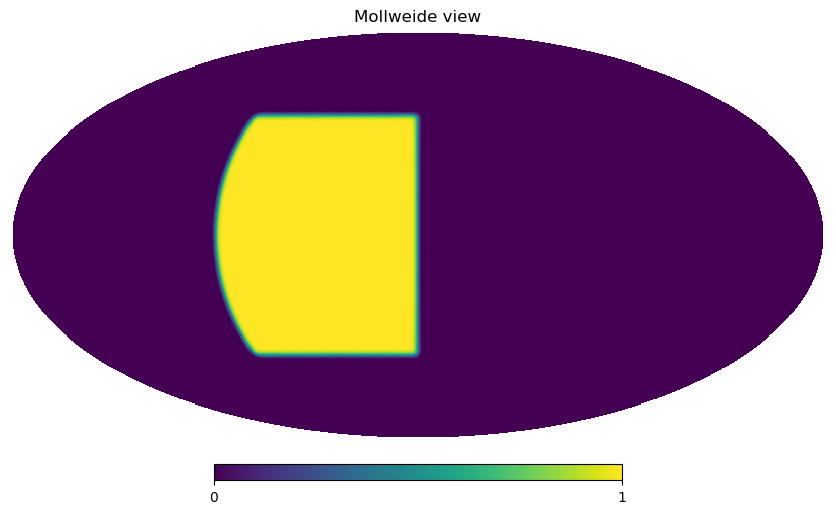

In [48]:
# Testing a large sky area and doing w2 and w2w4 at the same time for comparison of spectra - 20240220

# Example mask
ra = [0,90]
dec = [45,-45]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
hp.mollview(m)

m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [51]:
#Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_w2 = []
output_angles_w2w4 = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    # Calculating w2w4
    w2w4 = (np.mean(m_sm**2.)**2./np.mean(m_sm**4.))
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ClTT_rot_w2w4 = spectra_rotated[0][min_ell:max_ell] / w2w4
    ClEE_rot_w2w4 = spectra_rotated[1][min_ell:max_ell] / w2w4
    ClBB_rot_w2w4 = spectra_rotated[2][min_ell:max_ell] / w2w4
    ClTE_rot_w2w4 = spectra_rotated[3][min_ell:max_ell] / w2w4
    ClEB_rot_w2w4 = spectra_rotated[4][min_ell:max_ell] / w2w4
    ClTB_rot_w2w4 = spectra_rotated[5][min_ell:max_ell] / w2w4
    
    ClTT_unrot_w2w4 = spectra_unrotated[0][min_ell:max_ell] / w2w4
    ClEE_unrot_w2w4 = spectra_unrotated[1][min_ell:max_ell] / w2w4
    ClBB_unrot_w2w4 = spectra_unrotated[2][min_ell:max_ell] / w2w4
    ClTE_unrot_w2w4 = spectra_unrotated[3][min_ell:max_ell] / w2w4
    ClEB_unrot_w2w4 = spectra_unrotated[4][min_ell:max_ell] / w2w4
    ClTB_unrot_w2w4 = spectra_unrotated[5][min_ell:max_ell] / w2w4
    
    ClTT_cross12_w2w4 = spectra_cross12[0][min_ell:max_ell] / w2w4
    ClEE_cross12_w2w4 = spectra_cross12[1][min_ell:max_ell] / w2w4
    ClBB_cross12_w2w4 = spectra_cross12[2][min_ell:max_ell] / w2w4
    ClTE_cross12_w2w4 = spectra_cross12[3][min_ell:max_ell] / w2w4
    ClEB_cross12_w2w4 = spectra_cross12[4][min_ell:max_ell] / w2w4
    ClTB_cross12_w2w4 = spectra_cross12[5][min_ell:max_ell] / w2w4
    
    ClTT_cross21_w2w4 = spectra_cross21[0][min_ell:max_ell] / w2w4
    ClEE_cross21_w2w4 = spectra_cross21[1][min_ell:max_ell] / w2w4
    ClBB_cross21_w2w4 = spectra_cross21[2][min_ell:max_ell] / w2w4
    ClTE_cross21_w2w4 = spectra_cross21[3][min_ell:max_ell] / w2w4
    ClEB_cross21_w2w4 = spectra_cross21[4][min_ell:max_ell] / w2w4
    ClTB_cross21_w2w4 = spectra_cross21[5][min_ell:max_ell] / w2w4
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))

    estimator_w2w4 = ClEB_cross12_w2w4 - ClEB_cross21_w2w4
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance_w2w4 = ((ClEE_rot_w2w4*ClBB_unrot_w2w4+ClEB_cross12_w2w4**2) \
                  + (ClEE_unrot_w2w4*ClBB_rot_w2w4+ClEB_cross21_w2w4**2) \
                  - 2*(ClEE_cross12_w2w4*ClBB_cross12_w2w4+ClEB_rot_w2w4*ClEB_unrot_w2w4))
    
    fit_values_w2 = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    fit_values_w2w4 = sample_likelihood_and_fit(estimator_w2w4,covariance_w2w4,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle w2: " + str(fit_values_w2))
    print("Output angle w2w4: " + str(fit_values_w2w4))
    output_angles_w2.append(fit_values_w2)
    output_angles_w2w4.append(fit_values_w2w4)

print('w2  : ', w2)
print('w2w4: ', w2w4)
rot_degs = np.array(rot_degs)
output_angles_only_w2 = np.array(output_angles_w2)[:,0]
output_angles_only_w2w4 = np.array(output_angles_w2w4)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2 with w2: ")
print(output_angles_only_w2 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2 * -2.0 - rot_degs)/rot_degs)
print("Calculated angles scaled by -2 with w2w4: ")
print(output_angles_only_w2w4 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2w4 * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle w2: (-2.445265919739812, 0.11518979696194667)
Output angle w2w4: (-2.393236239804583, 0.11272729171775892)
Output angle w2: (-0.565920476604742, 0.026597849999020883)
Output angle w2w4: (-0.553906335476932, 0.026033052311890563)
Output angle w2: (3.530317829864056, 0.1667431446089816)
Output angle w2w4: (3.4550040024522857, 0.1631509329663991)
Output angle w2: (2.967318301503552, 0.13994295578310578)
Output angle w2w4: (2.9041086127470663, 0.13694121427636863)
Output angle w2: (1.4811340393950811, 0.06966507516050359)
Output angle w2w4: (1.4496668240556285, 0.06818246723355004)
Output angle w2: (-0.4560115274305966, 0.021431234865294177)
Output angle w2w4: (-0.44633112143525117, 0.020976209345457034)
Output angle w2: (-1.6338838224592354, 0.07686448019857937)
Output angle w2w4: (-1.5991647482859286, 0.07522773125241404)
Output angle w

0.1689694729471961


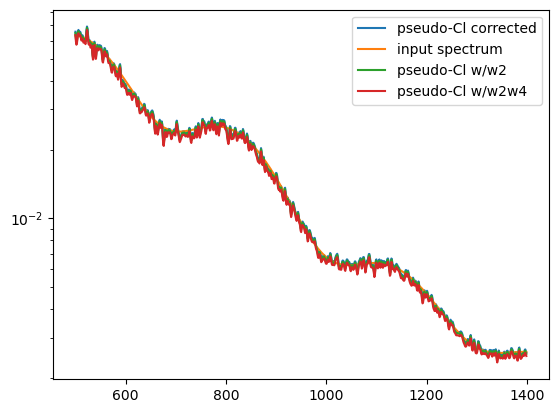

In [55]:
# Implementing Steve's empirical calibration for the mask correction factor
masked_spectrum = hp.anafast(unrot_sim_maps_masked[0])
correction = np.mean(masked_spectrum[min_ell:max_ell]/ClTT[min_ell-2:max_ell-2])
print(correction)
#plt.plot(ell_hp, masked_spectrum[min_ell:max_ell], label='pseudo-Cl')
plt.plot(ell_hp, masked_spectrum[min_ell:max_ell]/correction, label='pseudo-Cl corrected')
plt.plot(ell_hp, ClTT[min_ell-2:max_ell-2], label="input spectrum")
plt.plot(ell_hp, ClTT_unrot, label='pseudo-Cl w/w2')
plt.plot(ell_hp, ClTT_unrot_w2w4, label='pseudo-Cl w/w2w4')
plt.legend()
plt.yscale('log')
plt.show()

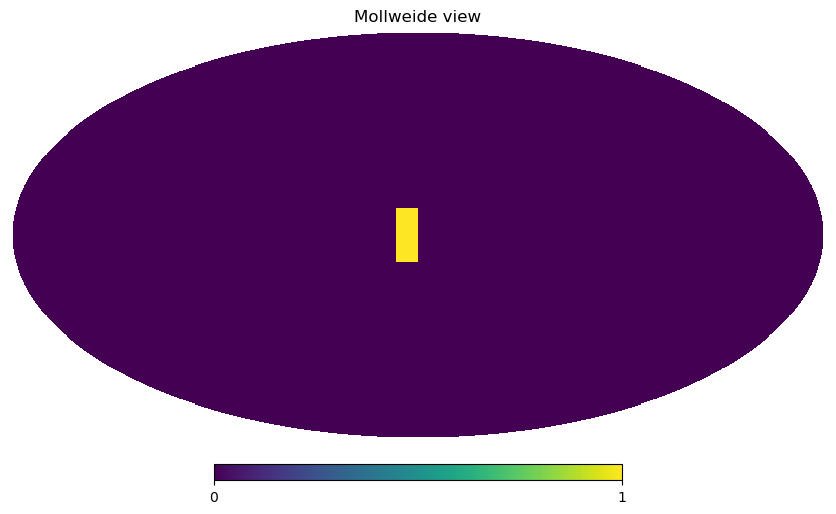

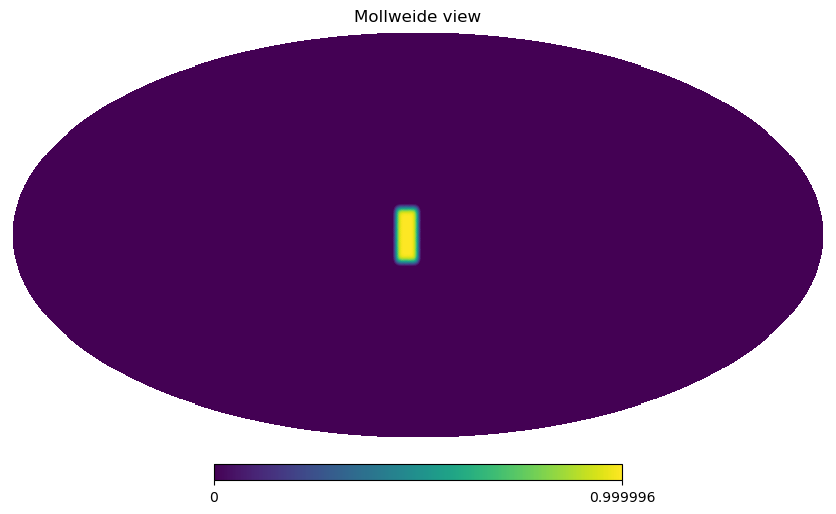

In [56]:
# Going back to a smaller sky area and doing w2 and w2w4 at the same time for comparison of spectra - 20240220

# Example mask
ra = [0,10]
dec = [10,-10]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
hp.mollview(m)

m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [57]:
#Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_w2 = []
output_angles_w2w4 = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    # Calculating w2w4
    w2w4 = (np.mean(m_sm**2.)**2./np.mean(m_sm**4.))
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ClTT_rot_w2w4 = spectra_rotated[0][min_ell:max_ell] / w2w4
    ClEE_rot_w2w4 = spectra_rotated[1][min_ell:max_ell] / w2w4
    ClBB_rot_w2w4 = spectra_rotated[2][min_ell:max_ell] / w2w4
    ClTE_rot_w2w4 = spectra_rotated[3][min_ell:max_ell] / w2w4
    ClEB_rot_w2w4 = spectra_rotated[4][min_ell:max_ell] / w2w4
    ClTB_rot_w2w4 = spectra_rotated[5][min_ell:max_ell] / w2w4
    
    ClTT_unrot_w2w4 = spectra_unrotated[0][min_ell:max_ell] / w2w4
    ClEE_unrot_w2w4 = spectra_unrotated[1][min_ell:max_ell] / w2w4
    ClBB_unrot_w2w4 = spectra_unrotated[2][min_ell:max_ell] / w2w4
    ClTE_unrot_w2w4 = spectra_unrotated[3][min_ell:max_ell] / w2w4
    ClEB_unrot_w2w4 = spectra_unrotated[4][min_ell:max_ell] / w2w4
    ClTB_unrot_w2w4 = spectra_unrotated[5][min_ell:max_ell] / w2w4
    
    ClTT_cross12_w2w4 = spectra_cross12[0][min_ell:max_ell] / w2w4
    ClEE_cross12_w2w4 = spectra_cross12[1][min_ell:max_ell] / w2w4
    ClBB_cross12_w2w4 = spectra_cross12[2][min_ell:max_ell] / w2w4
    ClTE_cross12_w2w4 = spectra_cross12[3][min_ell:max_ell] / w2w4
    ClEB_cross12_w2w4 = spectra_cross12[4][min_ell:max_ell] / w2w4
    ClTB_cross12_w2w4 = spectra_cross12[5][min_ell:max_ell] / w2w4
    
    ClTT_cross21_w2w4 = spectra_cross21[0][min_ell:max_ell] / w2w4
    ClEE_cross21_w2w4 = spectra_cross21[1][min_ell:max_ell] / w2w4
    ClBB_cross21_w2w4 = spectra_cross21[2][min_ell:max_ell] / w2w4
    ClTE_cross21_w2w4 = spectra_cross21[3][min_ell:max_ell] / w2w4
    ClEB_cross21_w2w4 = spectra_cross21[4][min_ell:max_ell] / w2w4
    ClTB_cross21_w2w4 = spectra_cross21[5][min_ell:max_ell] / w2w4
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))

    estimator_w2w4 = ClEB_cross12_w2w4 - ClEB_cross21_w2w4
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance_w2w4 = ((ClEE_rot_w2w4*ClBB_unrot_w2w4+ClEB_cross12_w2w4**2) \
                  + (ClEE_unrot_w2w4*ClBB_rot_w2w4+ClEB_cross21_w2w4**2) \
                  - 2*(ClEE_cross12_w2w4*ClBB_cross12_w2w4+ClEB_rot_w2w4*ClEB_unrot_w2w4))
    
    fit_values_w2 = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    fit_values_w2w4 = sample_likelihood_and_fit(estimator_w2w4,covariance_w2w4,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle w2: " + str(fit_values_w2))
    print("Output angle w2w4: " + str(fit_values_w2w4))
    output_angles_w2.append(fit_values_w2)
    output_angles_w2w4.append(fit_values_w2w4)

print('w2  : ', w2)
print('w2w4: ', w2w4)
rot_degs = np.array(rot_degs)
output_angles_only_w2 = np.array(output_angles_w2)[:,0]
output_angles_only_w2w4 = np.array(output_angles_w2w4)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2 with w2: ")
print(output_angles_only_w2 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2 * -2.0 - rot_degs)/rot_degs)
print("Calculated angles scaled by -2 with w2w4: ")
print(output_angles_only_w2w4 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2w4 * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle w2: (-2.379784664279477, 0.11266009619254057)
Output angle w2w4: (-1.9859659739130346, 0.09395093904566891)
Output angle w2: (-0.5507998299043376, 0.026018500494519595)
Output angle w2w4: (-0.4598057835788356, 0.021719345141080593)
Output angle w2: (3.4355356010912996, 0.16304667731018344)
Output angle w2w4: (2.8658935598350816, 0.13581341865812305)
Output angle w2: (2.887767682017859, 0.13685703065481447)
Output angle w2w4: (2.4094783938441116, 0.1140724002795984)
Output angle w2: (1.4415306773124488, 0.06814351963398088)
Output angle w2w4: (1.2032505996387388, 0.05686510580274804)
Output angle w2: (-0.4438280449874239, 0.020964499558612064)
Output angle w2w4: (-0.37050858490725597, 0.017500785273699783)
Output angle w2: (-1.5901879022784702, 0.07518452471818929)
Output angle w2w4: (-1.3272976695586227, 0.06273549589650208)
Output an

empirical correction:  0.00378239932367133
w2 :  0.003749871996345702
w2w4:  0.004491873709860829


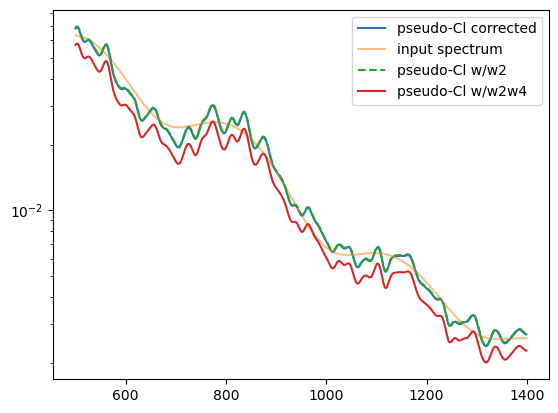

In [65]:
# Implementing Steve's empirical calibration for the mask correction factor
masked_spectrum = hp.anafast(unrot_sim_maps_masked[0])
correction = np.mean(masked_spectrum[min_ell:max_ell]/ClTT[min_ell-2:max_ell-2])
print("empirical correction: " ,correction)
print("w2 : ", w2)
print("w2w4: ", w2w4)
#plt.plot(ell_hp, masked_spectrum[min_ell:max_ell], label='pseudo-Cl')
plt.plot(ell_hp, masked_spectrum[min_ell:max_ell]/correction, label='pseudo-Cl corrected')
plt.plot(ell_hp, ClTT[min_ell-2:max_ell-2], alpha=0.5, label="input spectrum")
plt.plot(ell_hp, ClTT_unrot, '--', label='pseudo-Cl w/w2')
plt.plot(ell_hp, ClTT_unrot_w2w4, label='pseudo-Cl w/w2w4')
plt.legend()
plt.yscale('log')
plt.show()

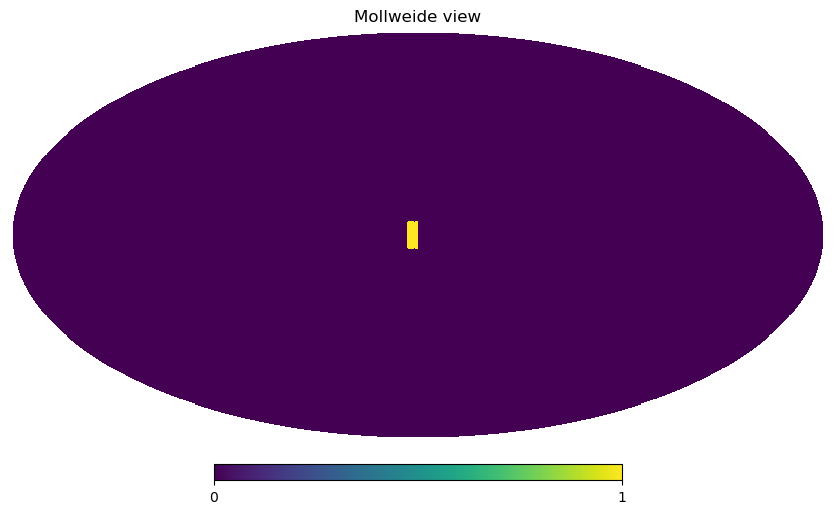

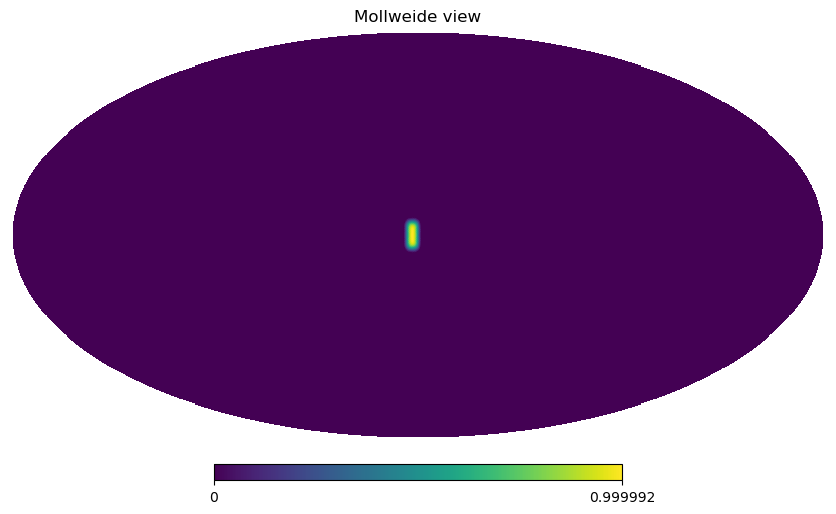

In [66]:
# Trying an even smaller sky area and doing w2 and w2w4 at the same time for comparison of spectra - 20240220

# Example mask
ra = [0,5]
dec = [5,-5]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
hp.mollview(m)

m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [67]:
#Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_w2 = []
output_angles_w2w4 = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    # Calculating w2w4
    w2w4 = (np.mean(m_sm**2.)**2./np.mean(m_sm**4.))
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ClTT_rot_w2w4 = spectra_rotated[0][min_ell:max_ell] / w2w4
    ClEE_rot_w2w4 = spectra_rotated[1][min_ell:max_ell] / w2w4
    ClBB_rot_w2w4 = spectra_rotated[2][min_ell:max_ell] / w2w4
    ClTE_rot_w2w4 = spectra_rotated[3][min_ell:max_ell] / w2w4
    ClEB_rot_w2w4 = spectra_rotated[4][min_ell:max_ell] / w2w4
    ClTB_rot_w2w4 = spectra_rotated[5][min_ell:max_ell] / w2w4
    
    ClTT_unrot_w2w4 = spectra_unrotated[0][min_ell:max_ell] / w2w4
    ClEE_unrot_w2w4 = spectra_unrotated[1][min_ell:max_ell] / w2w4
    ClBB_unrot_w2w4 = spectra_unrotated[2][min_ell:max_ell] / w2w4
    ClTE_unrot_w2w4 = spectra_unrotated[3][min_ell:max_ell] / w2w4
    ClEB_unrot_w2w4 = spectra_unrotated[4][min_ell:max_ell] / w2w4
    ClTB_unrot_w2w4 = spectra_unrotated[5][min_ell:max_ell] / w2w4
    
    ClTT_cross12_w2w4 = spectra_cross12[0][min_ell:max_ell] / w2w4
    ClEE_cross12_w2w4 = spectra_cross12[1][min_ell:max_ell] / w2w4
    ClBB_cross12_w2w4 = spectra_cross12[2][min_ell:max_ell] / w2w4
    ClTE_cross12_w2w4 = spectra_cross12[3][min_ell:max_ell] / w2w4
    ClEB_cross12_w2w4 = spectra_cross12[4][min_ell:max_ell] / w2w4
    ClTB_cross12_w2w4 = spectra_cross12[5][min_ell:max_ell] / w2w4
    
    ClTT_cross21_w2w4 = spectra_cross21[0][min_ell:max_ell] / w2w4
    ClEE_cross21_w2w4 = spectra_cross21[1][min_ell:max_ell] / w2w4
    ClBB_cross21_w2w4 = spectra_cross21[2][min_ell:max_ell] / w2w4
    ClTE_cross21_w2w4 = spectra_cross21[3][min_ell:max_ell] / w2w4
    ClEB_cross21_w2w4 = spectra_cross21[4][min_ell:max_ell] / w2w4
    ClTB_cross21_w2w4 = spectra_cross21[5][min_ell:max_ell] / w2w4
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))

    estimator_w2w4 = ClEB_cross12_w2w4 - ClEB_cross21_w2w4
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance_w2w4 = ((ClEE_rot_w2w4*ClBB_unrot_w2w4+ClEB_cross12_w2w4**2) \
                  + (ClEE_unrot_w2w4*ClBB_rot_w2w4+ClEB_cross21_w2w4**2) \
                  - 2*(ClEE_cross12_w2w4*ClBB_cross12_w2w4+ClEB_rot_w2w4*ClEB_unrot_w2w4))
    
    fit_values_w2 = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    fit_values_w2w4 = sample_likelihood_and_fit(estimator_w2w4,covariance_w2w4,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle w2: " + str(fit_values_w2))
    print("Output angle w2w4: " + str(fit_values_w2w4))
    output_angles_w2.append(fit_values_w2)
    output_angles_w2w4.append(fit_values_w2w4)

print('w2  : ', w2)
print('w2w4: ', w2w4)
rot_degs = np.array(rot_degs)
output_angles_only_w2 = np.array(output_angles_w2)[:,0]
output_angles_only_w2w4 = np.array(output_angles_w2w4)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2 with w2: ")
print(output_angles_only_w2 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2 * -2.0 - rot_degs)/rot_degs)
print("Calculated angles scaled by -2 with w2w4: ")
print(output_angles_only_w2w4 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2w4 * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle w2: (-2.345814583250992, 0.11170375996004418)
Output angle w2w4: (-1.5799701695021542, 0.07514380601373029)
Output angle w2: (-0.5429544372271201, 0.025800038241864658)
Output angle w2w4: (-0.3659104265957176, 0.017386151405275614)
Output angle w2: (3.3863733682091026, 0.16164523051723823)
Output angle w2w4: (2.279269855055533, 0.10852144718120026)
Output angle w2: (2.846501850022488, 0.1356889488257558)
Output angle w2w4: (1.9166310574678187, 0.09119901481847104)
Output angle w2: (1.4209833655404696, 0.06756928245682939)
Output angle w2w4: (0.9574489913635909, 0.04550739512732529)
Output angle w2: (-0.4375065901383649, 0.02078851104508867)
Output angle w2w4: (-0.29484996180027073, 0.01400946315981639)
Output angle w2: (-1.567517542775289, 0.07455037120623775)
Output angle w2w4: (-1.0561303611251178, 0.050201744706613136)
Output angle

empirical correction:  0.0007718760003048278
w2 :  0.0007400642044486104
w2w4:  0.0010981041183967938


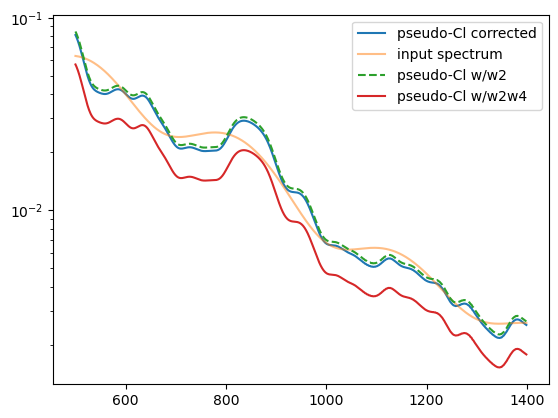

In [68]:
# Implementing Steve's empirical calibration for the mask correction factor
masked_spectrum = hp.anafast(unrot_sim_maps_masked[0])
correction = np.mean(masked_spectrum[min_ell:max_ell]/ClTT[min_ell-2:max_ell-2])
print("empirical correction: " ,correction)
print("w2 : ", w2)
print("w2w4: ", w2w4)
#plt.plot(ell_hp, masked_spectrum[min_ell:max_ell], label='pseudo-Cl')
plt.plot(ell_hp, masked_spectrum[min_ell:max_ell]/correction, label='pseudo-Cl corrected')
plt.plot(ell_hp, ClTT[min_ell-2:max_ell-2], alpha=0.5, label="input spectrum")
plt.plot(ell_hp, ClTT_unrot, '--', label='pseudo-Cl w/w2')
plt.plot(ell_hp, ClTT_unrot_w2w4, label='pseudo-Cl w/w2w4')
plt.legend()
plt.yscale('log')
plt.show()

In [69]:
# Checking Steve's updated get_hivon_fsky() from the Sensitivity-Calculator/Y1_simulations_231218.ipynb notebook
def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

In [70]:
print("empirical correction: " ,correction)
print("w2 : ", w2)
print("w2w4: ", w2w4)
print(get_hivon_fsky(m_sm))

empirical correction:  0.0007718760003048278
w2 :  0.0007400642044486104
w2w4:  0.0010981041183967938
0.0010981041183967934


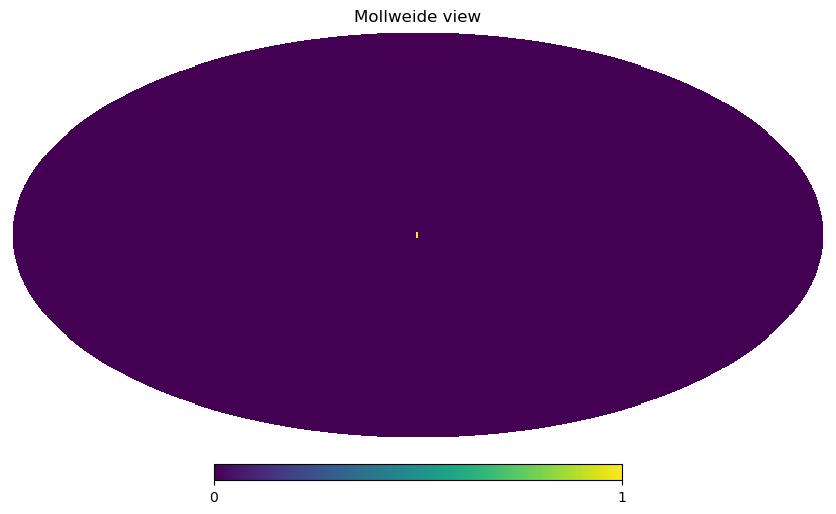

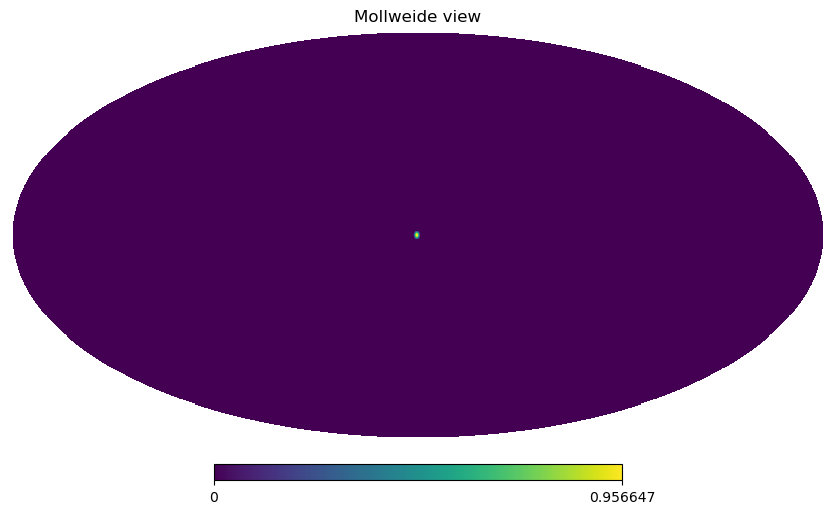

In [71]:
# Trying an even smaller sky area and doing w2 and w2w4 at the same time for comparison of spectra - 20240220

# Example mask
ra = [0,1]
dec = [1,-1]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
hp.mollview(m)

m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [72]:
#Now rotate the simulated maps, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_w2 = []
output_angles_w2w4 = []

unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)

#rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    # Calculating w2w4
    w2w4 = (np.mean(m_sm**2.)**2./np.mean(m_sm**4.))
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ClTT_rot_w2w4 = spectra_rotated[0][min_ell:max_ell] / w2w4
    ClEE_rot_w2w4 = spectra_rotated[1][min_ell:max_ell] / w2w4
    ClBB_rot_w2w4 = spectra_rotated[2][min_ell:max_ell] / w2w4
    ClTE_rot_w2w4 = spectra_rotated[3][min_ell:max_ell] / w2w4
    ClEB_rot_w2w4 = spectra_rotated[4][min_ell:max_ell] / w2w4
    ClTB_rot_w2w4 = spectra_rotated[5][min_ell:max_ell] / w2w4
    
    ClTT_unrot_w2w4 = spectra_unrotated[0][min_ell:max_ell] / w2w4
    ClEE_unrot_w2w4 = spectra_unrotated[1][min_ell:max_ell] / w2w4
    ClBB_unrot_w2w4 = spectra_unrotated[2][min_ell:max_ell] / w2w4
    ClTE_unrot_w2w4 = spectra_unrotated[3][min_ell:max_ell] / w2w4
    ClEB_unrot_w2w4 = spectra_unrotated[4][min_ell:max_ell] / w2w4
    ClTB_unrot_w2w4 = spectra_unrotated[5][min_ell:max_ell] / w2w4
    
    ClTT_cross12_w2w4 = spectra_cross12[0][min_ell:max_ell] / w2w4
    ClEE_cross12_w2w4 = spectra_cross12[1][min_ell:max_ell] / w2w4
    ClBB_cross12_w2w4 = spectra_cross12[2][min_ell:max_ell] / w2w4
    ClTE_cross12_w2w4 = spectra_cross12[3][min_ell:max_ell] / w2w4
    ClEB_cross12_w2w4 = spectra_cross12[4][min_ell:max_ell] / w2w4
    ClTB_cross12_w2w4 = spectra_cross12[5][min_ell:max_ell] / w2w4
    
    ClTT_cross21_w2w4 = spectra_cross21[0][min_ell:max_ell] / w2w4
    ClEE_cross21_w2w4 = spectra_cross21[1][min_ell:max_ell] / w2w4
    ClBB_cross21_w2w4 = spectra_cross21[2][min_ell:max_ell] / w2w4
    ClTE_cross21_w2w4 = spectra_cross21[3][min_ell:max_ell] / w2w4
    ClEB_cross21_w2w4 = spectra_cross21[4][min_ell:max_ell] / w2w4
    ClTB_cross21_w2w4 = spectra_cross21[5][min_ell:max_ell] / w2w4
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))

    estimator_w2w4 = ClEB_cross12_w2w4 - ClEB_cross21_w2w4
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance_w2w4 = ((ClEE_rot_w2w4*ClBB_unrot_w2w4+ClEB_cross12_w2w4**2) \
                  + (ClEE_unrot_w2w4*ClBB_rot_w2w4+ClEB_cross21_w2w4**2) \
                  - 2*(ClEE_cross12_w2w4*ClBB_cross12_w2w4+ClEB_rot_w2w4*ClEB_unrot_w2w4))
    
    fit_values_w2 = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    fit_values_w2w4 = sample_likelihood_and_fit(estimator_w2w4,covariance_w2w4,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle w2: " + str(fit_values_w2))
    print("Output angle w2w4: " + str(fit_values_w2w4))
    output_angles_w2.append(fit_values_w2)
    output_angles_w2w4.append(fit_values_w2w4)

print('w2  : ', w2)
print('w2w4: ', w2w4)
rot_degs = np.array(rot_degs)
output_angles_only_w2 = np.array(output_angles_w2)[:,0]
output_angles_only_w2w4 = np.array(output_angles_w2w4)[:,0]
print("Injected rotation angles: ")
print(rot_degs)
print("Calculated angles scaled by -2 with w2: ")
print(output_angles_only_w2 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2 * -2.0 - rot_degs)/rot_degs)
print("Calculated angles scaled by -2 with w2w4: ")
print(output_angles_only_w2w4 * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_w2w4 * -2.0 - rot_degs)/rot_degs)

Input angles are: [ 4.89685787  1.13332767 -7.06960426 -5.94225325 -2.9661396   0.91322139
  3.27203295 -1.30091115 -1.4916754  -0.73769668]
Output angle w2: (-2.1182343897040363, 0.10202234995578228)
Output angle w2w4: (-1.2026475338593572, 0.057852781753673733)
Output angle w2: (-0.4903770312375053, 0.02357783486420452)
Output angle w2w4: (-0.278582378496019, 0.013393645903666417)
Output angle w2: (3.0571428479719382, 0.14753490133483038)
Output angle w2w4: (1.7345345280117648, 0.08349179768098663)
Output angle w2: (2.5700911478442077, 0.12389205748602032)
Output angle w2w4: (1.4587585353697512, 0.07019226147460224)
Output angle w2: (1.283296954766934, 0.06173739773540224)
Output angle w2w4: (0.7288948830153363, 0.03505014628539152)
Output angle w2: (-0.3951418635570883, 0.01899818093703848)
Output angle w2w4: (-0.22448209564528507, 0.010792500932878922)
Output angle w2: (-1.4156090123625116, 0.06811257745881526)
Output angle w2w4: (-0.8040059577063359, 0.038663792064645326)
Output a

empirical correction:  5.8883940220733543e-05
w2 :  5.109627170783609e-05
w2w4:  8.993961576316384e-05


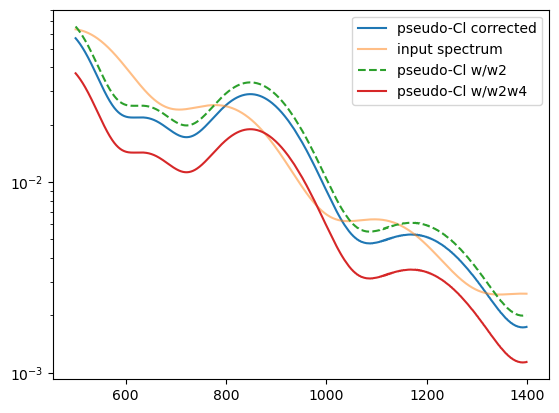

In [73]:
# Implementing Steve's empirical calibration for the mask correction factor
masked_spectrum = hp.anafast(unrot_sim_maps_masked[0])
correction = np.mean(masked_spectrum[min_ell:max_ell]/ClTT[min_ell-2:max_ell-2])
print("empirical correction: " ,correction)
print("w2 : ", w2)
print("w2w4: ", w2w4)
#plt.plot(ell_hp, masked_spectrum[min_ell:max_ell], label='pseudo-Cl')
plt.plot(ell_hp, masked_spectrum[min_ell:max_ell]/correction, label='pseudo-Cl corrected')
plt.plot(ell_hp, ClTT[min_ell-2:max_ell-2], alpha=0.5, label="input spectrum")
plt.plot(ell_hp, ClTT_unrot, '--', label='pseudo-Cl w/w2')
plt.plot(ell_hp, ClTT_unrot_w2w4, label='pseudo-Cl w/w2w4')
plt.legend()
plt.yscale('log')
plt.show()